In [1]:
#Step01 -- Initializing Spark

from pyspark import SparkContext, SparkConf 
from pyspark.sql import SparkSession

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]", appName="FIT5202 Assignment 2")

spark = SparkSession(sparkContext=sc)

In [2]:
#Step 02 -- Load,Read and print

weatherdf = spark.read.csv('weatherAUS.csv',inferSchema=True, header=True)
print("The total number of entries in the dataset is: ",weatherdf.count())

The total number of entries in the dataset is:  142193


In [7]:
#Step 03 - Delete columns

columns_to_drop=['Date','Location','Evaporation','Sunshine','Cloud9am','Cloud3pm','Temp9am','Temp3pm']
weatherdf = weatherdf.select([column for column in weatherdf.columns if column not in columns_to_drop])
print("Schema for the dataset")
print("------------------------------------------------------------------------------- ")
weatherdf.printSchema()

Schema for the dataset
------------------------------------------------------------------------------- 
root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [8]:
#Step 04 - Printing count of null values(NA) in each column

from pyspark.sql.functions import when, count, col

weatherdf.select([count(when(col(c)=='NA', c)).alias(c) for c in weatherdf.columns]).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|    637|    322|    1406|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



In [9]:
#Step 05 -- replace NA values in numeric column with mean

from pyspark.sql.functions import round,mean

weatherdf = weatherdf.withColumn('MinTemp', when(col('MinTemp')=='NA',weatherdf.select(round(mean(col('MinTemp')),2))\
                                        .first()[0]).otherwise(col('MinTemp')))\
        .withColumn('MaxTemp', when(col('MaxTemp')=='NA',weatherdf.select(round(mean(col('MaxTemp')),2))\
                                        .first()[0]).otherwise(col('MaxTemp')))\
        .withColumn('Rainfall', when(col('Rainfall')=='NA',weatherdf.select(round(mean(col('Rainfall')),2))\
                                         .first()[0]).otherwise(col('Rainfall')))\
        .withColumn('WindGustSpeed', when(col('WindGustSpeed')=='NA',weatherdf.select(round(mean(col('WindGustSpeed')),2))\
                                        .first()[0]).otherwise(col('WindGustSpeed')))\
        .withColumn('WindSpeed9am', when(col('WindSpeed9am')=='NA',weatherdf.select(round(mean(col('WindSpeed9am')),2))\
                                         .first()[0]).otherwise(col('WindSpeed9am')))\
        .withColumn('WindSpeed3pm', when(col('WindSpeed3pm')=='NA',weatherdf.select(round(mean(col('WindSpeed3pm')),2))\
                                         .first()[0]).otherwise(col('WindSpeed3pm')))\
        .withColumn('Humidity9am', when(col('Humidity9am')=='NA',weatherdf.select(round(mean(col('Humidity9am')),2))\
                                        .first()[0]).otherwise(col('Humidity9am')))\
        .withColumn('Humidity3pm', when(col('Humidity3pm')=='NA',weatherdf.select(round(mean(col('Humidity3pm')),2))\
                                        .first()[0]).otherwise(col('Humidity3pm')))\
        .withColumn('Pressure9am', when(col('Pressure9am')=='NA',weatherdf.select(round(mean(col('Pressure9am')),2))\
                                        .first()[0]).otherwise(col('Pressure9am')))\
        .withColumn('Pressure3pm', when(col('Pressure3pm')=='NA',weatherdf.select(round(mean(col('Pressure3pm')),2))\
                                        .first()[0]).otherwise(col('Pressure3pm')))

In [10]:
#Step 05 -- replace NA values in non-numeric column with frequency


weatherdf = weatherdf.withColumn('WindGustDir', when(col('WindGustDir')=='NA',weatherdf.select('WindGustDir')\
                    .groupBy('WindGustDir').count().sort('count',ascending=False).first()[0])\
                                 .otherwise(col('WindGustDir')))\
.withColumn('WindDir9am', when(col('WindDir9am')=='NA',weatherdf.select('WindDir9am')\
                    .groupBy('WindDir9am').count().sort('count',ascending=False).first()[0])\
                                .otherwise(col('WindDir9am')))\
.withColumn('WindDir3pm', when(col('WindDir3pm')=='NA',weatherdf.select('WindDir3pm')\
                    .groupBy('WindDir3pm').count().sort('count',ascending=False).first()[0])\
                                .otherwise(col('WindDir3pm')))\
.withColumn('RainToday', when(col('RainToday')=='NA',weatherdf.select('RainToday')\
                    .groupBy('RainToday').count().sort('count',ascending=False).first()[0])\
                                .otherwise(col('RainToday')))\
.withColumn('RainTomorrow', when(col('RainTomorrow')=='NA',weatherdf.select('RainTomorrow')\
                    .groupBy('RainTomorrow').count().sort('count',ascending=False).first()[0])\
                                .otherwise(col('RainTomorrow')))

In [11]:
#Step 06 -- Data Transformation 

#Splitting numeric and Non-numeric columns
numericColumns=['MinTemp',
                'MaxTemp',
                'Rainfall',
                'WindGustSpeed',
                'WindSpeed9am',
                'WindSpeed3pm',
                'Humidity9am',
                'Humidity3pm',
                'Pressure9am',
                'Pressure3pm']

nonNumericColumns=['WindGustDir',
                   'WindDir9am',
                   'WindDir3pm',
                   'RainToday',
                   'RainTomorrow']

#Here I am converting numeric columns into double type

for col_name in numericColumns:  
    weatherdf=weatherdf.withColumn(col_name, col(col_name).cast('double'))

In [12]:
#Step 06 -- Data Transformation 
#Here I'm using VectorAssembler transformation for data processing 

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["MinTemp","MaxTemp","Rainfall","WindGustSpeed",
                                "WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm","Pressure9am",
                                "Pressure3pm"],
                       outputCol="features")

weatherdf=assembler.transform(weatherdf)

weatherdf.show(truncate=False)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+-------------------------------------------------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|features                                               |
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+-------------------------------------------------------+
|13.4   |22.9   |0.6     |W          |44.0         |W         |WNW       |20.0        |24.0        |71.0       |22.0       |1007.7     |1007.1     |No       |No          |[13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1] |
|7.4    |25.1   |0.0     |WNW        |44.0         |NNW       |WSW       |4.0         |2

In [13]:
#Step 06 -- Data Transformation 
#Converting non-numeric columns into numeric using String Indexer

from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

#WindGustDir = StringIndexer(inputCol ="WindGustDir", outputCol = "windGustDirIndex")
#WindDir9am = StringIndexer(inputCol ="WindDir9am", outputCol = "windDir9amIndex")
#WindDir3pm = StringIndexer(inputCol ="WindDir3pm", outputCol = "windDir3pmIndex")
#RainToday = StringIndexer(inputCol ="RainToday", outputCol = "rainTodayIndex")
#RainTomo = StringIndexer(inputCol ="RainTomorrow", outputCol = "rainTomorrowIndex")


indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in nonNumericColumns ]
pipeline = Pipeline(stages=indexers)
weatherdf = pipeline.fit(weatherdf).transform(weatherdf)
weatherdf.show(truncate=False)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+-------------------------------------------------------+-----------------+----------------+----------------+---------------+------------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|features                                               |WindGustDir_index|WindDir9am_index|WindDir3pm_index|RainToday_index|RainTomorrow_index|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+-------------------------------------------------------+-----------------+----------------+----------------+---------------+------------------+
|13.4   |22.9   |0.6     |W          |44.0         |W  

In [ ]:
#from pyspark.ml import Pipeline

#pipeline = Pipeline(stages=[assembler, WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomo])
#pipelineFit = pipeline.fit(weatherdf)

#transformedData = pipelineFit.transform(weatherdf)
#transformedData.show(truncate=False)


In [14]:
#Step 07 - Random split

(trainingData, testData) = weatherdf.randomSplit([0.7, 0.3], seed = 100)

In [15]:
#Step 08 - Computing accuracy using machine learning algorithms
#Decision Tree Classifier

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dt = DecisionTreeClassifier(labelCol="RainTomorrow_index", featuresCol="features")
dtModel = dt.fit(trainingData)

dtPredictions = dtModel.transform(testData)

dtPredictions.select("MinTemp","MaxTemp","WindGustDir","WindGustSpeed","WindDir9am","WindDir3pm",
                   "WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm",
                   "probability","prediction","RainTomorrow_index")\
                .orderBy("probability", ascending=False).show(5)

evaluator = MulticlassClassificationEvaluator(\
labelCol="RainTomorrow_index", predictionCol="prediction",\
metricName="accuracy")

decisionTreeAccuracy = (evaluator.evaluate(dtPredictions))*100


print("Decision Tree Accuracy is: "+" "+"%.2f" % decisionTreeAccuracy)

#print("Test Error in DecisionTreeClassifier = %g " % (1.0 - decisionTreeAccuracy))


+-------+-------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+--------------------+----------+------------------+
|MinTemp|MaxTemp|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|         probability|prediction|RainTomorrow_index|
+-------+-------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+--------------------+----------+------------------+
|   -4.3|   16.5|        ESE|         44.0|         E|       ESE|        11.0|        30.0|       36.0|       23.0|[0.93062161330777...|       0.0|               0.0|
|   -4.0|   14.8|        ESE|         41.0|         E|       ESE|         7.0|        24.0|       54.0|       20.0|[0.93062161330777...|       0.0|               0.0|
|   -4.0|   16.2|        ESE|         54.0|       ESE|       ESE|         9.0|        28.0|       29.0|       27.0|[0.93062161330777...|       0.0|               0.0

In [16]:
#Step 08
#Random Forest

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(labelCol="RainTomorrow_index",\
featuresCol="features", numTrees=10)

rfModel = rf.fit(trainingData)

rfPredictions = rfModel.transform(testData)

#predictions.select("prediction", "RainTomorrow_index").show(5)
rfPredictions.select("MinTemp","MaxTemp","WindGustDir","WindGustSpeed","WindDir9am","WindDir3pm",\
                   "WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm",\
                   "probability","prediction","RainTomorrow_index")\
                .orderBy("probability", ascending=False).show(5)

evaluator =\
MulticlassClassificationEvaluator(labelCol="RainTomorrow_index",\
predictionCol="prediction", metricName="accuracy")

randomForestAccuracy = (evaluator.evaluate(rfPredictions))*100

print("Random Forest Accuracy is: "+" "+"%.2f" % randomForestAccuracy)

#print("Test Error in RandomForestClassifier = %g" % (1.0 - randomForestAccuracy))


+-------+-------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+--------------------+----------+------------------+
|MinTemp|MaxTemp|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|         probability|prediction|RainTomorrow_index|
+-------+-------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+--------------------+----------+------------------+
|   -3.4|   15.5|        ESE|         50.0|        SE|        SE|        13.0|        28.0|       54.0|       16.0|[0.90706906220291...|       0.0|               0.0|
|   -2.8|   23.5|          N|         28.0|       NNW|         W|         7.0|         9.0|       21.0|        9.0|[0.90706906220291...|       0.0|               0.0|
|   -3.4|   16.7|        ESE|         44.0|        SE|        SE|        13.0|        26.0|       56.0|       24.0|[0.90706906220291...|       0.0|               0.0

In [17]:
#Step 08

#Logistic expression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="RainTomorrow_index", featuresCol="features", maxIter=10)
lrModel = lr.fit(trainingData)

# LogicRegression.transform() is a method that uses only 'features'.
lrPredictions = lrModel.transform(testData)

lrPredictions.select("MinTemp","MaxTemp","WindGustDir","WindGustSpeed","WindDir9am","WindDir3pm",\
                   "WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm",\
                   "probability","prediction","RainTomorrow_index")\
                .orderBy("probability", ascending=False).show(5)

evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrow_index",\
predictionCol="prediction", metricName="accuracy")

logisticRegressionAccuracy = (evaluator.evaluate(lrPredictions))*100

print("Logistic Regression Accuracy is: "+" "+"%.2f" % logisticRegressionAccuracy)

+-------+-------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+--------------------+----------+------------------+
|MinTemp|MaxTemp|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|         probability|prediction|RainTomorrow_index|
+-------+-------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+--------------------+----------+------------------+
|    9.1|   35.3|          E|         26.0|       ESE|         S|         2.0|         9.0|       11.0|        5.0|[0.90607389956945...|       0.0|               0.0|
|   16.6|   35.3|        NNE|         22.0|       NNE|       SSW|         6.0|         4.0|       14.0|        8.0|[0.89998424527545...|       0.0|               0.0|
|   14.6|   37.3|          S|         28.0|       WSW|        NW|         4.0|        11.0|       11.0|        6.0|[0.89993161151859...|       0.0|               0.0

In [18]:
#Step 08

#GBT

from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="RainTomorrow_index", featuresCol="features",maxIter=10)
gbtModel = gbt.fit(trainingData)
gbtPredictions = gbtModel.transform(testData)

gbtPredictions.select("MinTemp","MaxTemp","WindGustDir","WindGustSpeed","WindDir9am","WindDir3pm",\
                   "WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm",\
                   "probability","prediction","RainTomorrow_index")\
                .orderBy("probability", ascending=False).show(5)

evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrow_index",\
predictionCol="prediction", metricName="accuracy")

gbtAccuracy = (evaluator.evaluate(gbtPredictions))*100

print("Logistic Regression Accuracy is: "+" "+"%.2f" % gbtAccuracy)

+-------+-------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+--------------------+----------+------------------+
|MinTemp|MaxTemp|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|         probability|prediction|RainTomorrow_index|
+-------+-------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+--------------------+----------+------------------+
|    2.1|   26.8|          N|         26.0|         N|       WSW|         0.0|         9.0|       34.0|       10.0|[0.92460119017675...|       0.0|               0.0|
|    4.6|   26.3|         NE|         31.0|       ESE|       ENE|         7.0|        15.0|       31.0|       10.0|[0.92460119017675...|       0.0|               0.0|
|   -1.4|   23.4|        NNW|         30.0|        NE|        NE|         9.0|        11.0|       37.0|       10.0|[0.92460119017675...|       0.0|               0.0

Text(0.5, 1.0, 'COMPARISON OF MACHINE LEARNING ALGORITHMS ACCURACY')

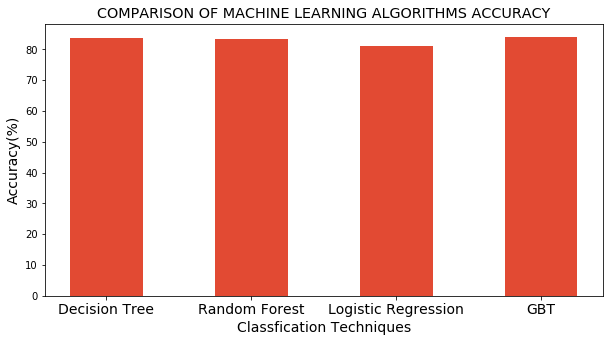

In [19]:
#Step 08 - Comparing accuracy using bar graphs

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
bar_width = 0.5

classificationList=('Decision Tree','Random Forest','Logistic Regression','GBT')
y_pos = np.arange(len(classificationList))
accuracyValues = [decisionTreeAccuracy,randomForestAccuracy,logisticRegressionAccuracy,gbtAccuracy]

plt.subplots(figsize=(10,5))
plt.style.use('ggplot')
plt.bar(y_pos,accuracyValues,bar_width, align='center', color='C0')
plt.xticks(y_pos,classificationList,fontsize=14)
plt.xlabel('Classfication Techniques',fontsize=14)
plt.ylabel('Accuracy(%)',fontsize=14)
plt.title('COMPARISON OF MACHINE LEARNING ALGORITHMS ACCURACY')

In [24]:
#Step 9 - Calculate confusion matrix

def confusionMatrix(predictions):
    TN=predictions.filter('prediction = 0.0 AND RainTomorrow_index = 0.0').count()
    FN=predictions.filter('prediction = 0.0 AND RainTomorrow_index = 1.0').count()
    TP=predictions.filter('prediction = 1.0 AND RainTomorrow_index = 1.0').count()
    FP=predictions.filter('prediction = 1.0 AND RainTomorrow_index = 0.0').count()
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*((precision*recall)/(precision+recall))
    return('precision = {:.2f}, recall = {:.2f}, f1Score = {:.2f}'.format(precision, recall, F1))
   

In [31]:
#Confusion Matrix for Decision Tree Classifier

print("Confusion Matrix for Decision Tree are : ",confusionMatrix(dtPredictions))

Confusion Matrix for Decision Tree are :  precision = 0.73, recall = 0.43, f1Score = 0.54


In [32]:
#Confusion Matrix for Random Forest

print("Confusion Matrix for Random Forest are : ",confusionMatrix(rfPredictions))

Confusion Matrix for Random Forest are :  precision = 0.76, recall = 0.39, f1Score = 0.51


In [34]:
#Confusion Matrix for Logistic Regression

print("Confusion Matrix for Logistic Regression are : ",confusionMatrix(lrPredictions))

Confusion Matrix for Logistic Regression are :  precision = 0.76, recall = 0.22, f1Score = 0.34


In [37]:
#Confusion Matrix for Gradient Boosting

print("Confusion Matrix for Gradient Boosting are : ",confusionMatrix(gbtPredictions))

Confusion Matrix for Gradient Boosting are :  precision = 0.74, recall = 0.43, f1Score = 0.55
